In [ ]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

In [ ]:
def reduce_mem_usage(data, verbose = True):
    
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [ ]:
def relational_tables_prepare(file_directory = '', verbose = True):
    '''
    Function to pickle the relational tables which would need to be merged during production with the 
    test datapoint
    
    Inputs:
        file_directory: str, default = ''
            The directory in which files are saved
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    
    if verbose:
        print("Loading the tables into memory...")
        start = datetime.now()
        
    #loading all the tables in memory, for dimensionality reduction
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose = False) 
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose = False)
    with open('Final_XGBOOST_Selected_features.pkl', 'rb') as f:
        final_cols = pickle.load(f)
        
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start}")
        start2 = datetime.now()
        print("\nRemoving the non-useful features...")
    #removing non-useful columns from pre-processed previous_application table
    previous_app_columns_to_keep = set(previous_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele] + [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]))
    previous_aggregated = previous_aggregated[previous_app_columns_to_keep]
    #removing non-useful columns from pre-processed credit_card_balance table
    credit_card_balance_columns_to_keep = set(cc_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele] + ['SK_ID_CURR']))
    cc_aggregated = cc_aggregated[credit_card_balance_columns_to_keep]
    #removing non-useful columns from pre-processed installments_payments table
    installments_payments_columns_to_keep = set(installments_aggregated.columns).intersection(set(final_cols)).union(
                                            set([ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in 
                                                 ele and 'RATIO' not in ele and 'DIFF' not in ele] + ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']))
    installments_aggregated = installments_aggregated[installments_payments_columns_to_keep]
    #removing non-useful columns from pre-processed bureau-aggregated table
    bureau_columns_to_keep =  set(bureau_aggregated.columns).intersection(set(final_cols)).union([ele for ele in bureau_aggregated.columns
                                        if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele] + [ele for ele in bureau_aggregated.columns if
                                        'AMT_CREDIT' in ele and 'OVERDUE' in ele] + [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele])
    bureau_aggregated = bureau_aggregated[bureau_columns_to_keep]
    
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start2}")
        print("\nMerging all the tables, and saving to pickle file 'relational_table.pkl'...")

    #merging all the tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = reduce_mem_usage(relational_table, verbose = False)

    with open(file_directory + 'relational_table.pkl', 'wb') as f:
        pickle.dump(relational_table, f)
    
    if verbose:
        print("Done.")
        print(f"Total Time taken = {datetime.now() - start}")

In [ ]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

In [ ]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for Cross Validation,
        uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, confusion_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if confusion_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

# Data Cleaning and Feature Engineering

In [ ]:
class preprocess_bureau_balance_and_bureau:
    '''
    Preprocess the tables bureau_balance and bureau.
    Contains 4 member functions:
        1. init method
        2. preprocess_bureau_balance method
        3. preprocess_bureau method
        4. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.start = datetime.now()
        
    def preprocess_bureau_balance(self):
        '''
        Function to preprocess bureau_balance table.
        This function first loads the table into memory, does some feature engineering, and finally
        aggregates the data over SK_ID_BUREAU
        
        Inputs:
            self
            
        Returns:
            preprocessed and aggregated bureau_balance table.
        '''
        
        if self.verbose:
            print('#######################################################')
            print('#          Pre-processing bureau_balance.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, bureau_balance.csv, into memory...")

        bureau_balance = pd.read_csv(self.file_directory + 'bureau_balance.csv')

        if self.verbose:
            print("Loaded bureau_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
        #it has 7 labels, we will label encode them
        #so we give C as 0, and rest increasing
        #also we will give X the benefit of doubt and keep it as middle value
        dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
        bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

        #weighing the status with the months_balance
        #converting months to positive
        bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
        bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

        #sorting the bureau_balance in ascending order of month and by the bureau SK_ID
        #this is done so as to make the rolling exponential average easily for previous months till current month
        bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        #we will do exponential weighted average on the encoded status
        #this is because if a person had a bad status 2 years ago, it should be given less weightage today
        # we keep the latent variable alpha = 0.8 
        #doing this for both weighted status and the status itself
        bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
        bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())    

        if self.verbose:
            print("Halfway through. A little bit more patience...")
            print(f"Total Time Elapsed = {datetime.now() - self.start}")

        #we can see that these datapoints are for 96 months i.e. 8 years.
        #so we will extract the means, and exponential averages for each year separately
        #first we convert month to year
        bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

        #defining our aggregations
        aggregations_basic = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','first'],
            'WEIGHTED_STATUS' : ['mean','sum','first'],
            'EXP_ENCODED_STATUS' : ['last'],
            'EXP_WEIGHTED_STATUS' : ['last']}

        #we will be finding aggregates for each year too
        aggregations_for_year = {
            'STATUS' : ['mean','max','last','first'],
            'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
            'EXP_WEIGHTED_STATUS' : ['last'],
            'EXP_ENCODED_STATUS' : ['last'] }

        #aggregating over whole dataset first
        aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
        aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

        #aggregating some of the features separately for latest 2 years
        aggregated_bureau_years = pd.DataFrame()
        for year in range(2):
            year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
            year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

            if year == 0:
                aggregated_bureau_years = year_group
            else:
                aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

        #aggregating for rest of the years
        aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
        aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]

        #merging with rest of the years
        aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
        aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')

        #filling the missing values obtained after aggregations with 0
        aggregated_bureau_balance.fillna(0, inplace = True)

        if self.verbose:
            print('Done preprocessing bureau_balance.')
            print(f"\nInitial Size of bureau_balance: {bureau_balance.shape}")
            print(f'Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: {aggregated_bureau_balance.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl')
            with open(self.file_directory + 'bureau_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(aggregated_bureau_balance, f)
            if self.verbose:
                print('Done.')     
        
        return aggregated_bureau_balance
    
    def preprocess_bureau(self, aggregated_bureau_balance):
        '''
        Function to preprocess the bureau table and merge it with the aggregated bureau_balance table.
        Finally aggregates the data over SK_ID_CURR for it to be merged with application_train table.
        
        Inputs:
            self
            aggregated_bureau_balance: DataFrame of aggregated bureau_balance table
        
        Returns:
            Final preprocessed, merged and aggregated bureau table
        '''
        
        if self.verbose:
            start2 = datetime.now()
            print('\n##############################################')
            print('#          Pre-processing bureau.csv         #')
            print('##############################################')
            print("\nLoading the DataFrame, bureau.csv, into memory...")

        bureau = pd.read_csv('bureau.csv')

        if self.verbose:
            print("Loaded bureau.csv")
            print(f"Time Taken to load = {datetime.now() - start2}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
        bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

        #from the EDA we saw some erroneous values in DAYS Fields, we will remove those
        #there are some loans which ended about very long ago, around 100 years ago.
        #Thus we will only keep those loans which have ended in past 50 years.
        bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
        bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
        #there is also a feature which tells about the number of days ago the Credit Report Came
        bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan
        
        #engineering some features based on domain knowledge
        bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
        bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
        bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
        bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
        bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
        bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

        #now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later    
        #firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
        aggregations_CREDIT_ACTIVE = {
                        'DAYS_CREDIT' : ['mean','min','max','last'],
                        'CREDIT_DAY_OVERDUE' : ['mean','max'],
                        'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                        'DAYS_ENDDATE_FACT' : ['mean','min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                        'CNT_CREDIT_PROLONG': ['max','sum'],
                        'AMT_CREDIT_SUM' : ['sum','max'],
                        'AMT_CREDIT_SUM_DEBT': ['sum'],
                        'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                        'DAYS_CREDIT_UPDATE' : ['mean','min'],
                        'AMT_ANNUITY' : ['mean','sum','max'],
                        'CREDIT_DURATION' : ['max','mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                        'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                        'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                        'STATUS_MEAN' : ['mean', 'max'],
                        'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                         }

        #we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
        #So we will aggregate them two separately and the remaining categories separately.
        categories_to_aggregate_on = ['Closed','Active']
        bureau_merged_aggregated_credit = pd.DataFrame()
        for i, status in enumerate(categories_to_aggregate_on):
            group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
            group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

            if i==0:
                bureau_merged_aggregated_credit = group
            else:
                bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')
        #aggregating for remaining categories
        bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                             (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
        bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

        #merging with other categories
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')

        #Encoding the categorical columns in one-hot form
        currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
        credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
        credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')

        #merging the one-hot encoded columns
        bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1), 
                                   currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)

        #aggregating the bureau_merged over all the columns
        bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
        bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
        #merging it with aggregates over categories
        bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')

        if self.verbose:
            print('Done preprocessing bureau and bureau_balance.')
            print(f"\nInitial Size of bureau: {bureau.shape}")
            print(f'Size of bureau and bureau_balance after Merging, Pre-Processing, Feature Engineering and Aggregation: {bureau_merged_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau and bureau_balance to bureau_merged_preprocessed.pkl')
            with open(self.file_directory + 'bureau_merged_preprocessed.pkl', 'wb') as f:
                pickle.dump(bureau_merged_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return bureau_merged_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of the bureau and bureau_balance tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and merged bureau and burea_balance tables
        '''
        
        #preprocessing the bureau_balance first
        aggregated_bureau_balance = self.preprocess_bureau_balance()
        #preprocessing the bureau table next, by combining it with the aggregated bureau_balance
        bureau_merged_aggregated = self.preprocess_bureau(aggregated_bureau_balance)
        
        return bureau_merged_aggregated

In [ ]:
bureau_aggregated = preprocess_bureau_balance_and_bureau(dump_to_pickle = True).main()

#######################################################
#          Pre-processing bureau_balance.csv          #
#######################################################

Loading the DataFrame, bureau_balance.csv, into memory...
Loaded bureau_balance.csv
Time Taken to load = 0:00:04.698606

Starting Data Cleaning and Feature Engineering...
Halfway through. A little bit more patience...
Total Time Elapsed = 0:14:37.993395
Done preprocessing bureau_balance.

Initial Size of bureau_balance: (27299925, 6)
Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: (817395, 40)

Total Time Taken = 0:14:53.292900

Pickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl
Done.

##############################################
#          Pre-processing bureau.csv         #
##############################################

Loading the DataFrame, bureau.csv, into memory...
Loaded bureau.csv
Time Taken to load = 0:00:02.573121

Starting Data Cleaning and Feature En

In [ ]:
class preprocess_previous_application:
    '''
    Preprocess the previous_application table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. preprocessing_feature_engineering method
        5. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the previous_application.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('########################################################')
            print('#        Pre-processing previous_application.csv        #')
            print('########################################################')
            print("\nLoading the DataFrame, previous_application.csv, into memory...")

        #loading the DataFrame into memory
        self.previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        self.initial_shape = self.previous_application.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the data. Removes erroneous points, fills categorical NaNs with 'XNA'.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print('\nStarting Data Cleaning...')
            
        #sorting the applications from oldest to most recent previous loans for each user
        self.previous_application = self.previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])
        
        #in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
        self.previous_application['DAYS_FIRST_DRAWING'][self.previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
        self.previous_application['DAYS_FIRST_DUE'][self.previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE_1ST_VERSION'][self.previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE'][self.previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_TERMINATION'][self.previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
        #we also see abruptly large value for SELLERPLACE_AREA
        self.previous_application['SELLERPLACE_AREA'][self.previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
        #filling the NaN values for categories
        categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        self.previous_application[categorical_columns] = self.previous_application[categorical_columns].fillna('XNA')
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

    def preprocessing_feature_engineering(self):
        '''
        Function to do preprocessing such as categorical encoding and feature engineering.
        
        Inputs: 
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Preprocessing and Feature Engineering...")

        #label encoding the categorical variables
        name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
        self.previous_application['NAME_CONTRACT_STATUS'] = self.previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
        yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
        self.previous_application['NAME_YIELD_GROUP'] = self.previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
        appl_per_contract_last_dict = {'Y':1, 'N':0}
        self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
        remaining_categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        for col in remaining_categorical_columns:
            encoding_dict = dict([(j,i) for i,j in enumerate(self.previous_application[col].unique(),1)])
            self.previous_application[col] = self.previous_application[col].map(encoding_dict)    
        
        #engineering some features on domain knowledge
        self.previous_application['MISSING_VALUES_TOTAL_PREV'] = self.previous_application.isna().sum(axis = 1)
        self.previous_application['AMT_DECLINED'] = self.previous_application['AMT_APPLICATION'] - self.previous_application['AMT_CREDIT']
        self.previous_application['AMT_CREDIT_GOODS_RATIO'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['AMT_CREDIT_GOODS_DIFF'] = self.previous_application['AMT_CREDIT'] - self.previous_application['AMT_GOODS_PRICE']
        self.previous_application['AMT_CREDIT_APPLICATION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['CREDIT_DOWNPAYMENT_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['GOOD_DOWNPAYMET_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['INTEREST_DOWNPAYMENT'] = self.previous_application['RATE_DOWN_PAYMENT'] * self.previous_application['AMT_DOWN_PAYMENT']
        self.previous_application['INTEREST_CREDIT'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIMARY']
        self.previous_application['INTEREST_CREDIT_PRIVILEGED'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIVILEGED']
        self.previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['DAYS_DECISION'] + 0.00001) * -1
        self.previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['SELLERPLACE_AREA'] + 0.00001)
        self.previous_application['ANNUITY'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['ANNUITY_GOODS'] = self.previous_application['AMT_GOODS_PRICE'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = self.previous_application['DAYS_LAST_DUE'] - self.previous_application['DAYS_FIRST_DUE']
        self.previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = self.previous_application['AMT_CREDIT'] * self.previous_application['HOUR_APPR_PROCESS_START']
        self.previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NFLAG_LAST_APPL_IN_DAY']
        self.previous_application['AMT_CREDIT_YIELD_GROUP'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NAME_YIELD_GROUP']
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application[
                                                'AMT_ANNUITY'] - self.previous_application['AMT_CREDIT'] 
        self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                                                                                'AMT_CREDIT'] + 0.00001)
        self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                            'AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
    
    def aggregations(self):
        '''
        Function to aggregate the previous applications over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated previous_applications
        '''
        
        if self.verbose:
            print("\nAggregating previous applications over SK_ID_CURR...")
            
        aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

        #grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
        group_last_3 = self.previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        #grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
        group_first_3 = self.previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        #grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
        group_all = self.previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

        #merging all the applications
        previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
        previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

        return previous_application_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of previous_application table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated previous_application table.
        '''
        
        #loading the DataFrame
        self.load_dataframe()
        
        #cleaning the data
        self.data_cleaning()
        
        #preprocessing the categorical features and creating new features
        self.preprocessing_feature_engineering()
        
        #aggregating data over SK_ID_CURR
        previous_application_aggregated = self.aggregations()
        
        if self.verbose:
            print('Done aggregations.')
            print(f"\nInitial Size of previous_application: {self.initial_shape}")
            print(f'Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: {previous_application_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed previous_application to previous_application_preprocessed.pkl')
            with open(self.file_directory + 'previous_application_preprocessed.pkl', 'wb') as f:
                pickle.dump(previous_application_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                    
        return previous_application_aggregated

In [ ]:
previous_aggregated = preprocess_previous_application(dump_to_pickle = True).main()

########################################################
#        Pre-processing previous_application.csv        #
########################################################

Loading the DataFrame, previous_application.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:07.764709

Starting Data Cleaning...
Done.
Time taken = 0:00:04.493986

Performing Preprocessing and Feature Engineering...
Done.
Time taken = 0:00:04.423341

Aggregating previous applications over SK_ID_CURR...
Done aggregations.

Initial Size of previous_application: (1670214, 37)
Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: (338857, 399)

Total Time Taken = 0:00:43.670236

Pickling pre-processed previous_application to previous_application_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


In [ ]:
class preprocess_installments_payments:
    '''
    Preprocess the installments_payments table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''
     
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        
    def load_dataframe(self):
        '''
        Function to load the installments_payments.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('##########################################################')
            print('#        Pre-processing installments_payments.csv        #')
            print('##########################################################')
            print("\nLoading the DataFrame, installments_payments.csv, into memory...")

        self.installments_payments = pd.read_csv(self.file_directory + 'installments_payments.csv')
        self.initial_shape = self.installments_payments.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function for pre-processing and feature engineering
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Pre-processing and Feature Engineering...")
        
        #sorting by SK_ID_PREV and NUM_INSTALMENT_NUMBER
        self.installments_payments = self.installments_payments.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending = True)
        
        #getting the total NaN values in the table
        self.installments_payments['MISSING_VALS_TOTAL_INSTAL'] = self.installments_payments.isna().sum(axis = 1)
        #engineering new features based on some domain based polynomial operations
        self.installments_payments['DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_INSTALMENT'] / (self.installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
        self.installments_payments['DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_INSTALMENT'] - self.installments_payments['DAYS_ENTRY_PAYMENT']
        self.installments_payments['AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT'] / (self.installments_payments['AMT_INSTALMENT'] + 0.00001)
        self.installments_payments['AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_INSTALMENT'] - self.installments_payments['AMT_PAYMENT']
        self.installments_payments['EXP_DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
    
    def aggregations_sk_id_prev(self):
        '''
        Function for aggregations of installments on previous loans over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            installments_payments table aggregated over previous loans
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Aggregations over SK_ID_PREV...")
        
        #aggregating the data over SK_ID_PREV, i.e. for each previous loan
        overall_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL' : ['sum'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }
        limited_period_aggregations = {
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }

        #aggregating installments_payments over SK_ID_PREV for last 1 year installments
        group_last_1_year = self.installments_payments[self.installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_last_1_year.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in group_last_1_year.columns]
        #aggregating installments_payments over SK_ID_PREV for first 5 installments
        group_first_5_instalments = self.installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_first_5_instalments.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in group_first_5_instalments.columns]
        #overall aggregation of installments_payments over SK_ID_PREV
        group_overall = self.installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(overall_aggregations)
        group_overall.columns = ['_'.join(ele).upper() for ele in group_overall.columns]
        group_overall.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

        #merging all of the above aggregations together
        installments_payments_agg_prev = group_overall.merge(group_last_1_year, on = 'SK_ID_PREV', how = 'outer')
        installments_payments_agg_prev = installments_payments_agg_prev.merge(group_first_5_instalments, on = 'SK_ID_PREV', how = 'outer')
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
        return installments_payments_agg_prev
    
    def aggregations_sk_id_curr(self, installments_payments_agg_prev):
        '''
        Function to aggregate the installments payments on previous loans over SK_ID_CURR
        
        Inputs:
            self
            installments_payments_agg_prev: DataFrame
                installments payments aggregated over SK_ID_PREV
        
        Returns:
            installments payments aggregated over SK_ID_CURR
        '''
                    
        #aggregating over SK_ID_CURR
        main_features_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL_SUM' : ['sum'],
            'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
            'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
            'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
            'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
            'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
            'AMT_INSTALMENT_MAX' : ['mean'],
            'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
            'AMT_PAYMENT_SUM' : ['mean','sum','max'],
            'AMT_PAYMENT_MAX' : ['mean'],
            'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
            'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
            'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
            'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
            'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
            'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
            'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
            'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
            'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
            'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean']
        }

        grouped_main_features = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(main_features_aggregations)
        grouped_main_features.columns = ['_'.join(ele).upper() for ele in grouped_main_features.columns]

        #group remaining ones
        grouped_remaining_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

        installments_payments_aggregated = grouped_main_features.merge(grouped_remaining_features, on = 'SK_ID_CURR', how = 'inner')
                
        return installments_payments_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of installments_payments table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated installments_payments table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #doing pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #First aggregating the data for each SK_ID_PREV
        installments_payments_agg_prev = self.aggregations_sk_id_prev()
    
        if self.verbose:
            print("\nAggregations over SK_ID_CURR...")
        #aggregating the previous loans for each SK_ID_CURR
        installments_payments_aggregated = self.aggregations_sk_id_curr(installments_payments_agg_prev)
        
        if self.verbose:
            print('\nDone preprocessing installments_payments.')
            print(f"\nInitial Size of installments_payments: {self.initial_shape}")
            print(f'Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: {installments_payments_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed installments_payments to installments_payments_preprocessed.pkl')
            with open(self.file_directory + 'installments_payments_preprocessed.pkl', 'wb') as f:
                pickle.dump(installments_payments_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return installments_payments_aggregated   

In [ ]:
installments_aggregated = preprocess_installments_payments(dump_to_pickle = True).main()

##########################################################
#        Pre-processing installments_payments.csv        #
##########################################################

Loading the DataFrame, installments_payments.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:10.421198

Starting Data Pre-processing and Feature Engineering...
Done.
Time Taken = 0:00:15.651146

Performing Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:21.160019

Aggregations over SK_ID_CURR...

Done preprocessing installments_payments.

Initial Size of installments_payments: (13605401, 8)
Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: (339587, 101)

Total Time Taken = 0:00:51.415838

Pickling pre-processed installments_payments to installments_payments_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


In [ ]:
class preprocess_application_train_test:
    '''
    Preprocess the application_train and application_test tables.
    Contains 11 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. ext_source_values_predictor method
        5. numeric_feature_engineering method
        6. neighbors_EXT_SOURCE_feature method
        7. categorical_interaction_features method
        8. response_fit method
        9. response_transform method
        10. cnt_payment_prediction method
        11. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.file_directory = file_directory
        
    def load_dataframes(self):
        '''
        Function to load the application_train.csv and application_test.csv DataFrames.
        
        Inputs:
            self
            
        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#######################################################')
            print('#        Pre-processing application_train.csv         #')
            print('#        Pre-processing application_test.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.application_train = pd.read_csv(self.file_directory + 'application_train.csv')
        self.application_test = pd.read_csv(self.file_directory + 'application_test.csv')
        self.initial_shape = self.application_train.shape
        
        if self.verbose:
            print("Loaded application_train.csv and application_test.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the tables, by removing erroneous rows/entries.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            print("\nPerforming Data Cleaning...")
        
        #there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']
        self.application_train = self.application_train.drop(flag_cols_to_drop, axis = 1)
        self.application_test = self.application_test.drop(flag_cols_to_drop, axis = 1)
        #converting age from days to years
        self.application_train['DAYS_BIRTH'] = self.application_train['DAYS_BIRTH'] * -1 / 365
        self.application_test['DAYS_BIRTH'] = self.application_test['DAYS_BIRTH'] * -1 / 365
        #From the EDA we saw some erroneous values in DAYS_EMPLOYED field
        self.application_train['DAYS_EMPLOYED'][self.application_train['DAYS_EMPLOYED'] == 365243] = np.nan
        self.application_test['DAYS_EMPLOYED'][self.application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        #OBS Columns have an erroneous value, we'll remove those values
        self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #there were also 4 rows with 'XNA' as Gender, removing these rows
        self.application_train = self.application_train[self.application_train['CODE_GENDER'] != 'XNA']
        #filling the categorical columns with 'XNA' value
        categorical_columns = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        self.application_train[categorical_columns] = self.application_train[categorical_columns].fillna('XNA')
        self.application_test[categorical_columns] = self.application_test[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
        self.application_train['REGION_RATING_CLIENT'] = self.application_train['REGION_RATING_CLIENT'].astype('object')
        self.application_train['REGION_RATING_CLIENT_W_CITY'] = self.application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
        self.application_test['REGION_RATING_CLIENT'] = self.application_test['REGION_RATING_CLIENT'].astype('object')
        self.application_test['REGION_RATING_CLIENT_W_CITY'] = self.application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        self.application_train['MISSING_VALS_TOTAL_APP'] = self.application_train.isna().sum(axis = 1)
        self.application_test['MISSING_VALS_TOTAL_APP'] = self.application_test.isna().sum(axis = 1)

        if self.verbose:
            print("Done.")
            
    def ext_source_values_predictor(self):
        '''
        Function to predict the missing values of EXT_SOURCE features
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPredicting the missing values of EXT_SOURCE columns...")
            
        #predicting the EXT_SOURCE missing values
        #using only numeric columns for predicting the EXT_SOURCES
        columns_for_modelling = list(set(self.application_test.dtypes[self.application_test.dtypes != 'object'].index.tolist())
                                             - set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','SK_ID_CURR']))
        with open('columns_for_ext_values_predictor.pkl', 'wb') as f:
            pickle.dump(columns_for_modelling, f)
        
        #we'll train an XGB Regression model for predicting missing EXT_SOURCE values
        #we will predict in the order of least number of missing value columns to max.
        for ext_col in ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']:
            #X_model - datapoints which do not have missing values of given column
            #Y_train - values of column trying to predict with non missing values
            #X_train_missing - datapoints in application_train with missing values
            #X_test_missing - datapoints in application_test with missing values
            X_model, X_train_missing, X_test_missing, Y_train = self.application_train[~self.application_train[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                self.application_train[ext_col].isna()][columns_for_modelling], self.application_test[
                                                                self.application_test[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                ext_col][~self.application_train[ext_col].isna()]
            xg = XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, n_jobs = -1, random_state = 59)
            xg.fit(X_model, Y_train)
            #dumping the model to pickle file
            with open(f'nan_{ext_col}_xgbr_model.pkl', 'wb') as f:
                pickle.dump(xg, f)

            self.application_train[ext_col][self.application_train[ext_col].isna()] = xg.predict(X_train_missing)
            self.application_test[ext_col][self.application_test[ext_col].isna()] = xg.predict(X_test_missing)
            
            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]
            
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
                    
    def numeric_feature_engineering(self, data):
        '''
        Function to perform feature engineering on numeric columns based on domain knowledge.
        
        Inputs:
            self
            data: DataFrame
                The tables of whose features are to be generated
        
        Returns: 
            None
        '''
    
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        cnt_payment = self.cnt_payment_prediction(data)
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
                    
        return data
    
    def neighbors_EXT_SOURCE_feature(self):
        '''
        Function to generate a feature which contains the means of TARGET of 500 neighbors of a particular row.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
        #imputing the mean of 500 nearest neighbor's target values for each application
        #neighbors are computed using EXT_SOURCE feature and CREDIT_ANNUITY_RATIO
        
        knn = KNeighborsClassifier(500, n_jobs = -1)
        
        train_data_for_neighbors = self.application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        #saving the training data for neighbors
        with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
            pickle.dump(train_data_for_neighbors, f)
        train_target = self.application_train.TARGET
        test_data_for_neighbors = self.application_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        
        knn.fit(train_data_for_neighbors, train_target)
        #pickling the knn model
        with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
            pickle.dump(knn, f)
            
        train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
        test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]
        
        #adding the means of targets of 500 neighbors to new column
        self.application_train['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
        self.application_test['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in test_500_neighbors]
    
    def categorical_interaction_features(self, train_data, test_data):
        '''
        Function to generate some features based on categorical groupings.
        
        Inputs:
            self
            train_data, test_data : DataFrames
                train and test dataframes
        
        Returns:
            Train and test datasets, with added categorical interaction features.
        '''
        
        #now we will create features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']

        ]
        aggregations = {
            'AMT_ANNUITY' : ['mean','max','min'],
            'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
            'AGE_EMPLOYED_DIFF' : ['mean','min'],
            'AMT_INCOME_TOTAL' : ['mean','max','min'],
            'APARTMENTS_SUM_AVG' : ['mean','max','min'],
            'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
            'EXT_SOURCE_MEAN' : ['mean','max','min'],
            'EXT_SOURCE_1' : ['mean','max','min'],
            'EXT_SOURCE_2' : ['mean','max','min'],
            'EXT_SOURCE_3' : ['mean','max','min']
        }
        
        #extracting values
        for group in columns_to_aggregate_on:
            #grouping based on categories
            grouped_interactions = train_data.groupby(group).agg(aggregations) 
            grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
            #saving the grouped interactions to pickle file
            group_name = '_'.join(group)
            with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
                pickle.dump(grouped_interactions, f)
            #merging with the original data
            train_data = train_data.join(grouped_interactions, on = group)
            test_data = test_data.join(grouped_interactions, on = group)

        return train_data, test_data

    def response_fit(self, data, column):
        '''
        Response Encoding Fit Function
        Function to create a vocabulary with the probability of occurrence of each category for categorical features
        for a given class label.
        
        Inputs:
            self
            data: DataFrame
                training Dataset
            column: str
                the categorical column for which vocab is to be generated
        
        Returns:
            Dictionary of probability of occurrence of each category in a particular class label.
        '''
        
        dict_occurrences = {1: {}, 0: {}}
        for label in [0,1]:
            dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

        return dict_occurrences

    def response_transform(self, data, column, dict_mapping):
        '''
        Response Encoding Transform Function
        Function to transform the categorical feature into two features, which contain the probability
        of occurrence of that category for each class label.
        
        Inputs:
            self
            data: DataFrame
                DataFrame whose categorical features are to be encoded
            column: str
                categorical column whose encoding is to be done
            dict_mapping: dict
                Dictionary obtained from Response Fit function for that particular column
        
        Returns:
            None
        '''
        
        data[column + '_0'] = data[column].map(dict_mapping[0])
        data[column + '_1'] = data[column].map(dict_mapping[1])
    
    def cnt_payment_prediction(self, data_to_predict):
        '''
        Function to predict the Count_payments on Current Loans using data from previous loans.
        
        Inputs:
            self
            data_to_predict: DataFrame
                the values using which the model would predict the Count_payments on current applications
        
        Returns:
            Predicted Count_payments of the current applications.
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        previous_application = pd.read_csv('previous_application.csv')
        train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
        train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
        #value to predict is our CNT_PAYMENT
        train_value = train_data.pop('CNT_PAYMENT')
        
        #test data would be our application_train data
        test_data = data_to_predict[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        
        lgbmr = LGBMRegressor(max_depth = 9, n_estimators = 5000, n_jobs = -1, learning_rate = 0.3, 
                              random_state = 125)
        lgbmr.fit(train_data, train_value)
        #dumping the model to pickle file
        with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
            pickle.dump(lgbmr, f)
        #predicting the CNT_PAYMENT for test_data
        cnt_payment = lgbmr.predict(test_data)
        
        return cnt_payment

    def main(self):
        '''
        Function to be called for complete preprocessing of application_train and application_test tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed application_train and application_test tables.
        '''

        #loading the DataFrames first
        self.load_dataframes()
        #first doing Data Cleaning
        self.data_cleaning()
        #predicting the missing values of EXT_SOURCE columns
        self.ext_source_values_predictor()
        
        #doing the feature engineering
        if self.verbose:
            start = datetime.now()
            print("\nStarting Feature Engineering...")
            print("\nCreating Domain Based Features on Numeric Data")
        #Creating Numeric features based on domain knowledge
        self.application_train = self.numeric_feature_engineering(self.application_train)
        self.application_test = self.numeric_feature_engineering(self.application_test)
        #500 Neighbors Target mean
        self.neighbors_EXT_SOURCE_feature()
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        if self.verbose:
            start = datetime.now()
            print("Creating features based on Categorical Interactions on some Numeric Features")
        #creating features based on categorical interactions
        self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)   
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
        
        #using response coding on categorical features, to keep the dimensionality in check
        #categorical columns to perform response coding on
        categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        for col in categorical_columns_application:
            #extracting the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            mapping_dictionary = self.response_fit(self.application_train, col)
            #saving the mapping dictionary to pickle file
            with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
                pickle.dump(mapping_dictionary, f)
            #mapping this dictionary with our DataFrame
            self.response_transform(self.application_train, col, mapping_dictionary)
            self.response_transform(self.application_test, col, mapping_dictionary)
            #removing the original categorical columns
            _ = self.application_train.pop(col)
            _ = self.application_test.pop(col)
        
        if self.verbose:
            print('Done preprocessing appplication_train and application_test.')
            print(f"\nInitial Size of application_train: {self.initial_shape}")
            print(f'Size of application_train after Pre-Processing and Feature Engineering: {self.application_train.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed application_train and application_test to application_train_preprocessed.pkl and application_test_preprocessed, respectively.')
            with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_train, f)
            with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_test, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                        
        return self.application_train, self.application_test

In [ ]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

#######################################################
#        Pre-processing application_train.csv         #
#        Pre-processing application_test.csv          #
#######################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded application_train.csv and application_test.csv
Time Taken to load = 0:00:03.119648

Performing Data Cleaning...
Done.

Predicting the missing values of EXT_SOURCE columns...
Done.
Time elapsed = 0:07:13.534705

Starting Feature Engineering...

Creating Domain Based Features on Numeric Data
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Done.
Time Taken = 0:04:15.408749
Creating features based on Categorical Interactions on some Numeric Features
Done.
Time taken = 0:00:03.256461
Done preprocessing appplication_train and application_test.

Initial Size of application_train: (307511, 122)
Size of application_train after Pre-Processing and Featur

In [ ]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated, 
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Function to merge all the tables together with the application_train and application_test tables
    on SK_ID_CURR.
    
    Inputs:
        All the previously pre-processed Tables.
        
    Returns:
        Single merged tables, one for training data and one for test data
    '''

    #merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)

In [ ]:
train_data, test_data = merge_all_tables(application_train, application_test, 
                                         bureau_aggregated, previous_aggregated, 
                                         installments_aggregated, pos_aggregated, 
                                         cc_aggregated)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 3631.75 MB
Memory usage after optimization: 1277.15 MB
Decreased by 64.8%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 575.31 MB
Memory usage after optimization: 208.07 MB
Decreased by 63.8%
----------------------------------------------------------------------------------------------------


In [ ]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 24 columns with just 1 unique value
Removing these from dataset


In [ ]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''
    
    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.
        
        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection
                
        Returns: 
            None
        '''
        
        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state
        
    def main(self):
        '''
        Function to select features recursively
        
        Inputs:
            self
        
        Returns:
            Training and testing data with reduced number of features
        '''
        
        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()
            
        #set of important features
        self.important_columns = set()
        score = 1
        i = 1
        
        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")
                
            #removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis = 1)
            #defining the CV strategry
            fold = StratifiedKFold(n_splits = self.num_folds, shuffle = True, random_state = 33)
            #reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)
            
            #doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train),1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")
                
                #defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]
                
                #instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs = -1, random_state = self.random_state)
                lg.fit(x_train, y_train)

                #appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                #average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:,1]) / self.num_folds

            #getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            #names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]
            
            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1
            
        self.important_columns = list(self.important_columns)
        
        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")
            
        #saving the final columns into a pickle file
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(train_data.columns.tolist(), f)
        
        gc.collect()

        return self.train_data, self.test_data

In [ ]:
#instantiating the class recursive_feature_selector
feature_selector =  recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns

Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1144
	Cross Validation score = 0.7979487508522838
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1236
	Cross Validation score = 0.713068903611207

Done Selecting Features.
Total columns removed = 371

Initial Shape of train_data = (307507, 1607)
Final Shape of train_data = (307507, 1236)

Total Time Taken = 0:06:40.073256


In [ ]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

Training Dataset Results:
	ROC-AUC Score = 0.5001144672273913
	Precision Score = 0.08085142403208793
	Recall Score = 0.5001812688821752
Confusion Matrix of Training data:


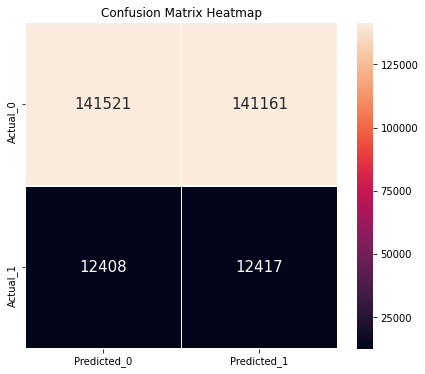

Distribution of Original Class Labels and Predicted Train and Test Class Labels


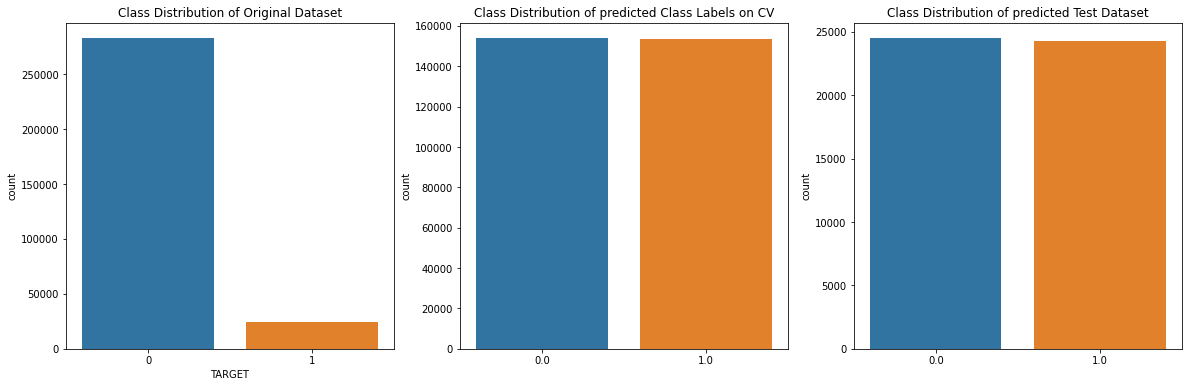

In [ ]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(train_data))
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Random_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Random_Model.csv -m "Random Model Predictions"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


Training Dataset Results:
	ROC-AUC Score = 0.5010095061750377
	Precision Score = 0.0
	Recall Score = 0.0
Confusion Matrix of Training data:


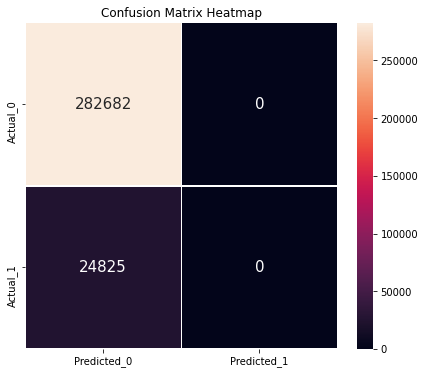

Distribution of Original Class Labels and Predicted Train and Test Class Labels


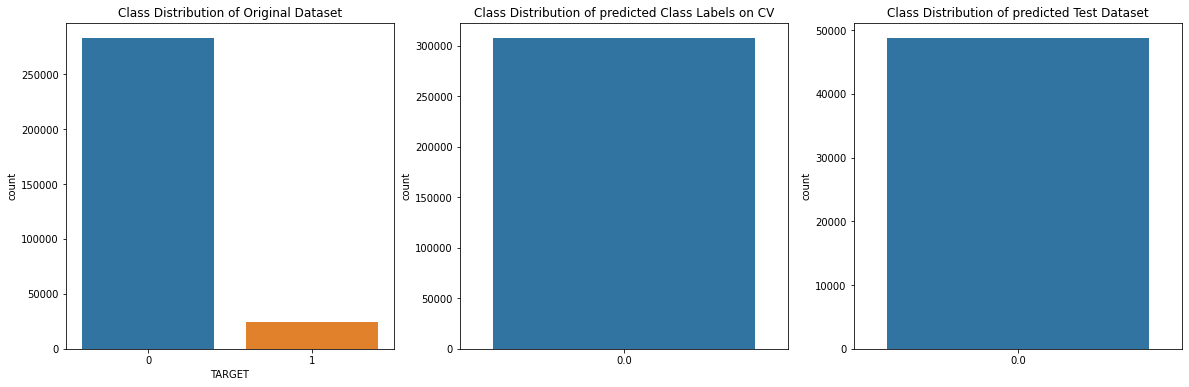

In [ ]:
#predicting everything with probability less than 0.5, i.e majority class
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Dominant_Class_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Dominant_Class_Model.csv -m "Predicted probabilities between 0 to 0.5, with a threshold of 0.5"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [ ]:
params = {
    'n_jobs' : -1,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = RandomForestClassifier(**params)
hyperparams = {
    'n_estimators' : list(range(500, 1500)),
    'max_depth' : list(range(10,30)),
    'min_samples_split' : list(range(5,50)),
    'min_samples_leaf' : list(range(2,50)),
    'max_samples' : uniform(0,1)   
}

rf = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
rf.random_search_cv(hyperparams, n_iter = 10, n_jobs = -1, random_state = 4281)

Doing Randomized Search CV on Classifier with 10 random initializations...
Done.
Time elapsed = 6:57:37.402256


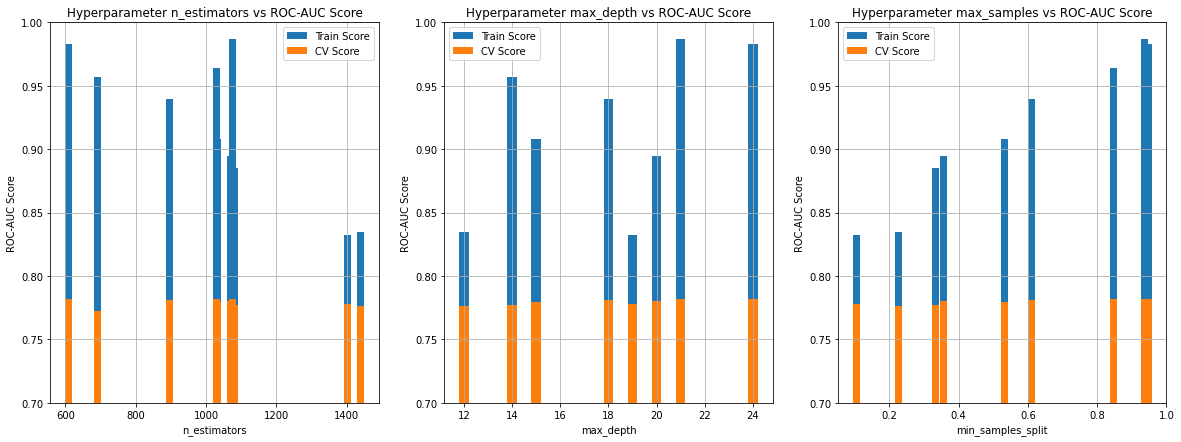

In [ ]:
cv_results = rf.tuning_results

#lets plot the ROC-AUC for different Hyperparameters
plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
cv_results = cv_results.sort_values('param_n_estimators')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_train_score'], width = 20, label = 'Train Score')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_test_score'], width = 20, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter n_estimators vs ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
cv_results = cv_results.sort_values('param_max_depth')
plt.bar(cv_results['param_max_depth'], cv_results['mean_train_score'], width = 0.4, label = 'Train Score')
plt.bar(cv_results['param_max_depth'], cv_results['mean_test_score'], width = 0.4, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_depth vs ROC-AUC Score')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
cv_results = cv_results.sort_values('param_min_samples_split')
plt.bar(cv_results['param_max_samples'], cv_results['mean_train_score'], width = 0.02, label = 'Train Score')
plt.bar(cv_results['param_max_samples'], cv_results['mean_test_score'], width = 0.02, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_samples vs ROC-AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC Score')

plt.legend()
plt.grid()
plt.show()

In [ ]:
cv_results['Train_CV_Score_Difference'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

#lets look at the differences between the train and CV scores
print("Checking out the differences between Train and CV Scores for each set of hyperparameters:\n")
display(cv_results[['params', 'mean_test_score', 'mean_train_score', 'Train_CV_Score_Difference']])

Checking out the differences between Train and CV Scores for each set of hyperparameters:



,params,mean_test_score,mean_train_score,Train_CV_Score_Difference
0,"{'max_depth': 20, 'max_samples': 0.35680763572...",0.780275,0.894752,0.114477
1,"{'max_depth': 12, 'max_samples': 0.22686425497...",0.776438,0.834836,0.058398
2,"{'max_depth': 21, 'max_samples': 0.93803728255...",0.781808,0.986608,0.204800
3,"{'max_depth': 14, 'max_samples': 0.93717204395...",0.772099,0.957212,0.185114
4,"{'max_depth': 19, 'max_samples': 0.10549276374...",0.777634,0.832294,0.054660
5,"{'max_depth': 24, 'max_samples': 0.94708311766...",0.781768,0.983299,0.201531
6,"{'max_depth': 15, 'max_samples': 0.53224896818...",0.779553,0.907749,0.128196
7,"{'max_depth': 21, 'max_samples': 0.84676766673...",0.782033,0.963820,0.181787
8,"{'max_depth': 18, 'max_samples': 0.60961236108...",0.780783,0.939672,0.158889
9,"{'max_depth': 14, 'max_samples': 0.33224831069...",0.777256,0.885575,0.108319


Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:22:39.932666

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.3117067855413637

Train Results:
	ROC-AUC Score = 0.8321734127843617
	Precision Score = 0.18841218624545078
	Recall Score = 0.8091440080563947
CV Results:
	ROC-AUC Score = 0.7775905555143139
	Precision Score = 0.1702748219443582
	Recall Score = 0.7290231621349446
Confusion Matrix of CV data:


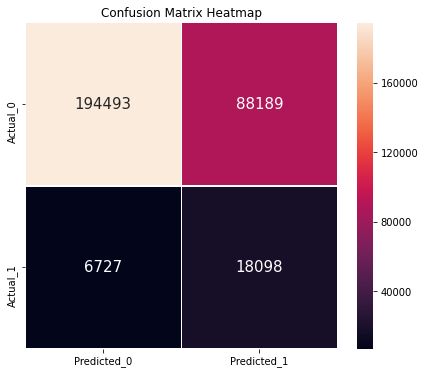

Distribution of Original Class Labels and Predicted CV and Test Class Labels


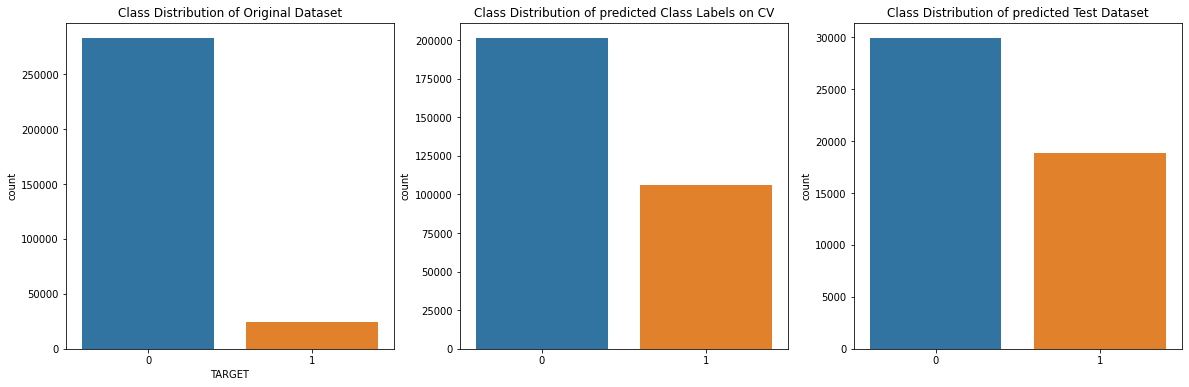

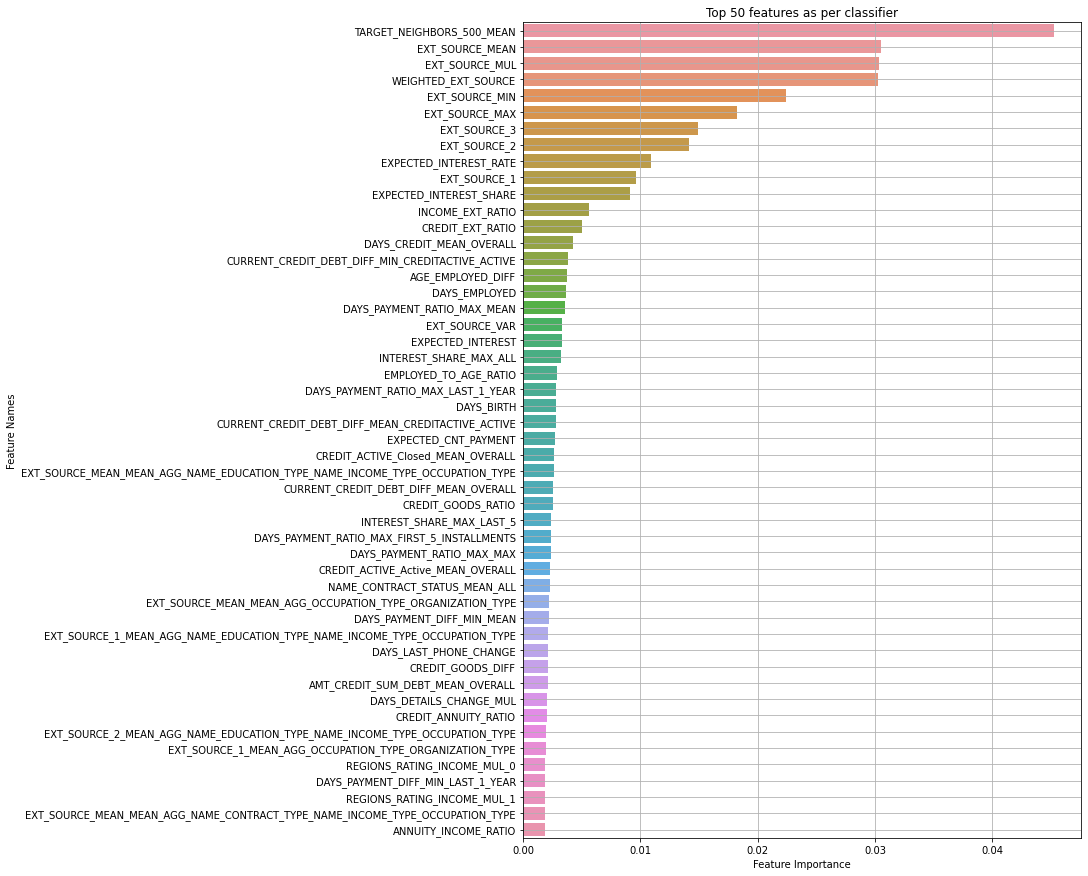

In [ ]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 19,
                                       max_samples = 0.105493, min_samples_leaf = 26,
                                       min_samples_split = 44, n_estimators = 1403, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : rf.test_preds_probas}).to_csv('Random_Forest.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Random_Forest.csv -m ""
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [ ]:
with open('Random_Forest_CV_Preds.pkl', 'wb') as f:
    pickle.dump(rf.cv_preds_probas, f)

with open('Random_Forest_Test_Preds.pkl', 'wb') as f:
    pickle.dump(rf.test_preds_probas, f)

with open('Random_Forest_Model.pkl', 'wb') as f:
    pickle.dump(rf.best_model, f)

In [ ]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 39,
        'max_depth' : 9,
        'min_split_gain' : 0.030820727751758883,
        'min_child_weight' : 30.074868967458226,
        'min_child_samples' : 31,
        'subsample': 0.7653763123038788,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.6175714684701181,
        'reg_alpha' : 0.15663020002553255,
        'reg_lambda' : 0.22503178038757748,
        'verbosity' : -1,
        'seed' : 266
    }
lgbm_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.802937	training's binary_logloss: 0.234464	valid_1's auc: 0.789224	valid_1's binary_logloss: 0.239426
[800]	training's auc: 0.82343	training's binary_logloss: 0.224254	valid_1's auc: 0.798703	valid_1's binary_logloss: 0.233861
[1200]	training's auc: 0.838173	training's binary_logloss: 0.217647	valid_1's auc: 0.803017	valid_1's binary_logloss: 0.231842
[1600]	training's auc: 0.850186	training's binary_logloss: 0.21232	valid_1's auc: 0.805329	valid_1's binary_logloss: 0.230847
[2000]	training's auc: 0.86093	training's binary_logloss: 0.207573	valid_1's auc: 0.80677	valid_1's binary_logloss: 0.230248
[2400]	training's auc: 0.870626	training's binary_logloss: 0.203199	valid_1's auc: 0.807622	valid_1's binary_logloss: 0.229899
[2800]	training's auc: 0.879223	training'


The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.05066106742670391

Train Results:
	ROC-AUC Score = 0.9045251207764887
	Precision Score = 0.28059423818773765
	Recall Score = 0.8262638469284995
CV Results:
	ROC-AUC Score = 0.8061038615922426
	Precision Score = 0.15404830803755978
	Recall Score = 0.8406042296072508
Confusion, Precision and Recall Matrix on CV data:


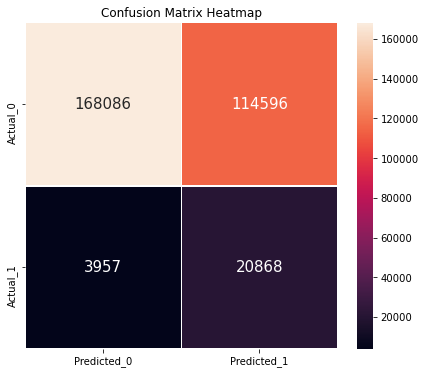

Distribution of Original Class Labels and Predicted CV and Test Class Labels


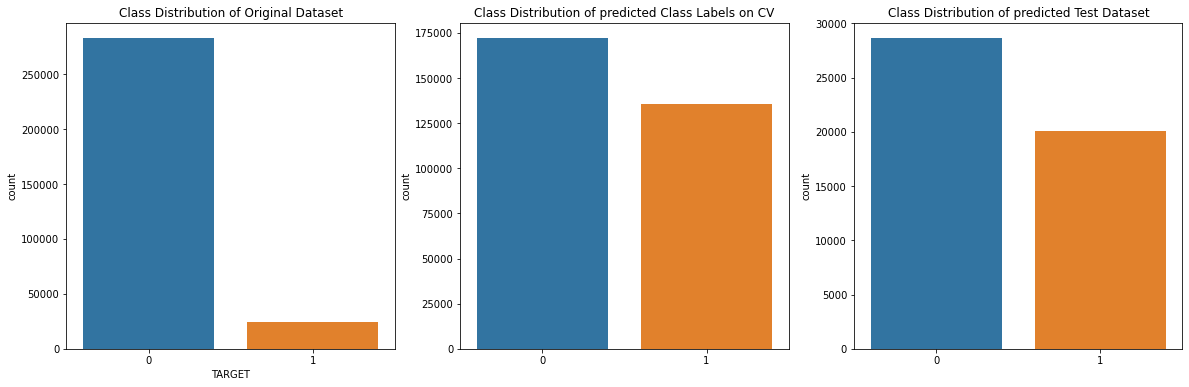

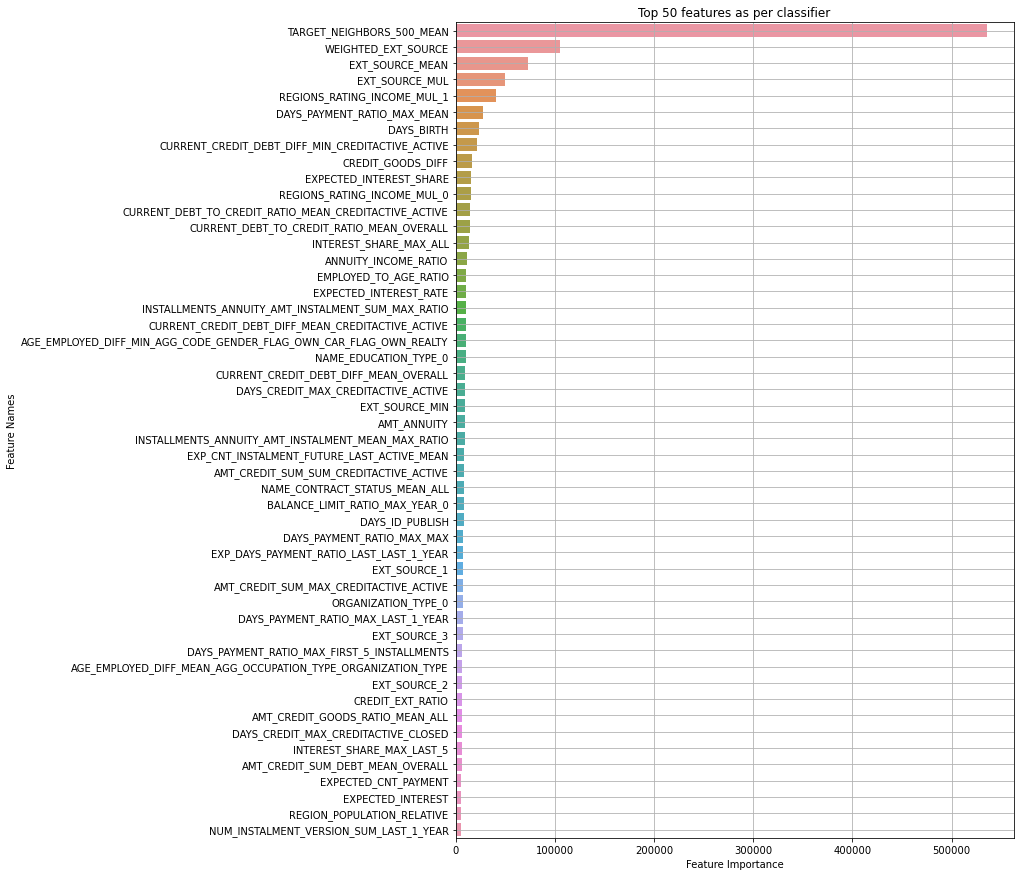

In [ ]:
#displaying the results and metrics
lgbm_boosting.results()
#displaying top 50 important features
lgbm_boosting.feat_importances_show(50)

In [ ]:
features_with_zero_importances  = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in LGBMClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 41 features with Zero Gain in LGBMClassifier. They are:

['EXT_SOURCE_3_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE'
 'CURRENT_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL'
 'CURRENCY_currency 4_MEAN_OVERALL' 'CURRENCY_currency 3_MEAN_OVERALL'
 'CREDIT_ACTIVE_Bad debt_MEAN_OVERALL'
 'CREDIT_DAY_OVERDUE_MEAN_CREDITACTIVE_CLOSED'
 'CREDIT_DURATION_MEAN_OVERALL'
 'CREDIT_TYPE_Another type of loan_MEAN_OVERALL'
 'EXT_SOURCE_2_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY'
 'CURRENCY_currency 2_MEAN_OVERALL'
 'CREDIT_TYPE_Cash loan (non-earmarked)_MEAN_OVERALL'
 'CREDIT_TYPE_Real estate loan_MEAN_OVERALL'
 'CREDIT_TYPE_Loan for working capital replenishment_MEAN_OVERALL'
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN_OVERALL'
 'CREDIT_TYPE_Interbank credit_MEAN_OVERALL'
 'EXT_SOURCE_3_MIN_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE'
 'AMT_CREDIT_SUM_OVERDUE_MAX_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MAX_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDAT

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : lgbm_boosting.test_preds_proba_mean}).to_csv('LGBM_3folds.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_3folds.csv -m "LightGBM - 3 Folds Submission"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [ ]:
with open('lgbm_imp_feats.pkl','wb') as f:
    pickle.dump(lgbm_boosting.feature_importance, f)
with open('lgbm_cv_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.cv_preds_proba, f)
with open('lgbm_test_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.test_preds_proba_mean, f)

In [ ]:
def load_stacking_data(file_directory = '', verbose = True):
    '''
    Objective function to prepare the Stacking Training and Test Data. The training data is the
    Out-Of-Fold predictions of each base learners, and the test data are the predicted probabilities
    on the Test data.
    
    Inputs:
        file_directory: str, default = ''
            The path of directory where the predictions are located. Insert '/' in the end
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        Training stacking data, Test stacking data, Trainig target values
    '''

    if verbose:
        print("Loading the CV (out-of-folds) and Test Predictions from Base Models...")
        start = datetime.now()
        
    global sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv
    global sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test
    
    with open(file_directory + 'SGD_LR_L2_Penalty_CV_Preds.pkl', 'rb') as f:
        sgd_lr_l2_cv = pickle.load(f)
    with open(file_directory + 'SGD_Linear_SVM_CV_Preds.pkl', 'rb') as f:
        sgd_svm_cv = pickle.load(f)
    with open(file_directory + 'Random_Forest_CV_Preds.pkl', 'rb') as f:
        rf_cv = pickle.load(f)
    with open(file_directory + 'xgb_cv_preds_600feats.pkl', 'rb') as f:
        xgb_cv = pickle.load(f)
    with open(file_directory + 'lgbm_cv_preds.pkl', 'rb') as f:
        lgbm_cv = pickle.load(f)

    #loading the Predicted Probabilities of Test Set
    sgd_lr_l2_test = pd.read_csv(file_directory + 'SGD_L2_Penalty.csv')['TARGET']
    sgd_svm_test = pd.read_csv(file_directory + 'SGD_Linear_SVM.csv')['TARGET']
    rf_test = pd.read_csv(file_directory + 'Random_Forest.csv')['TARGET']
    xgb_test = pd.read_csv(file_directory + 'XGBoost_600_features.csv')['TARGET']
    lgbm_test = pd.read_csv(file_directory + 'LGBM_3folds.csv')['TARGET']
    
    if verbose:
        print("Making the Training and Test Dataset for Stacking...")
    #defining the training and test datasets
    stack_train = pd.DataFrame(np.stack([sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv], axis = 1), 
                              columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM'])
    stack_target = target_train.copy()
    stack_test = pd.concat([sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test], axis = 1)
    stack_test.columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM']
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")
        print(f"Shape of stacking training data = {stack_train.shape}")
        print(f"Shape of stacking test data = {stack_test.shape}")
        print(f"Shape of stacking training class labels = {stack_target.shape}")
        
    return stack_train, stack_test, stack_target

In [ ]:
stack_train, stack_test, stack_target = load_stacking_data()

Loading the CV (out-of-folds) and Test Predictions from Base Models...
Making the Training and Test Dataset for Stacking...
Done.
Time elapsed = 0:00:01.398851
Shape of stacking training data = (307507, 5)
Shape of stacking test data = (48744, 5)
Shape of stacking training class labels = (307507,)


In [ ]:
def lgbm_stacker_optimization(num_leaves, max_depth, min_split_gain, min_child_weight,
                             min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 8956
    }
    stratified_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 96)
    
    cv_preds = np.zeros(stack_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(stack_train, stack_target):

        x_tr = stack_train.iloc[train_indices]
        y_tr = stack_target.iloc[train_indices]
        x_cv = stack_train.iloc[cv_indices]
        y_cv = stack_target.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(stack_target, cv_preds)

In [ ]:
bopt_stacking = BayesianOptimization(lgbm_stacker_optimization, {'num_leaves' : (2,50),
                                                   'max_depth' : (2,6),
                                                   'min_split_gain' : (0, 0.5),
                                                   'min_child_weight' : (1,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.001,1),
                                                   'colsample_bytree' : (0.2,1),
                                                   'reg_alpha' : (0.00001, 0.3),
                                                   'reg_lambda' : (0.00001, 0.3)},
                                 random_state = 6569)

bayesian_optimization = bopt_stacking.maximize(n_iter = 10, init_points = 10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8049   |  0.7955   |  5.417    |  44.35    |  38.21    |  0.4826   |  19.51    |  0.06595  |  0.05161  |  0.5286   |
|  2        |  0.8062   |  0.7451   |  4.236    |  47.4     |  58.14    |  0.1048   |  47.96    |  0.2365   |  0.249    |  0.7261   |
|  3        |  0.8066   |  0.6329   |  4.483    |  32.69    |  24.78    |  0.3669   |  2.316    |  0.09315  |  0.09452  |  0.4668   |
|  4        |  0.8048   |  0.4877   |  4.83     |  70.16    |  64.09    |  0.2487   |  22.81    |  0.2672   |  0.01726  |  0.4483   |
|  5        |  0.804    |  0.3603   |  5.12     |  68.84    |  64.73    |  0.1149   |  9.906    |  0.1364   |  0.05073  |  0.1665   |
|  6        |  0.7767   |  0.273    |  2.604    |  26.55    | 

In [ ]:
#extracting the best parameters
target_values = []
for result in bopt_stacking.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.653278704808709, 'max_depth': 5.074653064311349, 'min_child_samples': 31.571358671994325, 'min_child_weight': 25.462380118091218, 'min_split_gain': 0.10600273039230335, 'num_leaves': 3.046971981281322, 'reg_alpha': 0.17957695696091033, 'reg_lambda': 0.13028216024797987, 'subsample': 0.5194861616343917}


In [ ]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 3,
        'max_depth' : 5,
        'min_split_gain' : 0.10600273039230335,
        'min_child_weight' : 25.462380118091218,
        'min_child_samples' : 32,
        'subsample': 0.5194861616343917,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.653278704808709,
        'reg_alpha' : 0.17957695696091033,
        'reg_lambda' : 0.13028216024797987,
        'verbosity' : -1,
        'seed' : 266
    }
stacker_boosting = Boosting(stack_train, stack_target, stack_test, params, random_state = 96, num_folds = 4)
stacker_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 4 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.807551	training's binary_logloss: 0.232847	valid_1's auc: 0.804045	valid_1's binary_logloss: 0.233456
[800]	training's auc: 0.808043	training's binary_logloss: 0.229993	valid_1's auc: 0.804446	valid_1's binary_logloss: 0.230817
[1200]	training's auc: 0.808147	training's binary_logloss: 0.229643	valid_1's auc: 0.804465	valid_1's binary_logloss: 0.230537
[1600]	training's auc: 0.808348	training's binary_logloss: 0.229534	valid_1's auc: 0.804545	valid_1's binary_logloss: 0.230481
[2000]	training's auc: 0.808539	training's binary_logloss: 0.229458	valid_1's auc: 0.804588	valid_1's binary_logloss: 0.230459
[2400]	training's auc: 0.808698	training's binary_logloss: 0.229397	valid_1's auc: 0.804616	valid_1's binary_logloss: 0.230449
Early stopping, best iteration is:
[2

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.026947135695858375

	ROC-AUC Score = 0.807872515009856
	Precision Score = 0.1913304532474189
	Recall Score = 0.736797583081571
CV Results:
	ROC-AUC Score = 0.8066312491185976
	Precision Score = 0.11773016722003007
	Recall Score = 0.9398590130916414


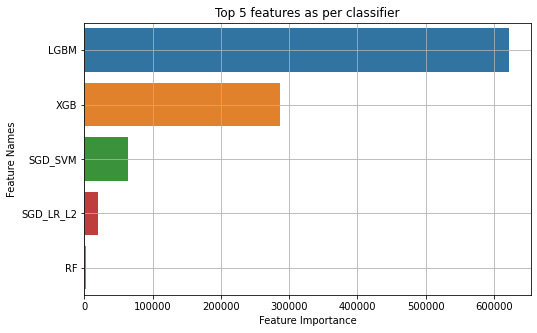

In [ ]:
#displaying the results and metrics
stacker_boosting.results(confusion_matrix = False, cv_test_distribution = False)
#displaying top 50 important features
stacker_boosting.feat_importances_show(5, figsize = (8,5))

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : stacker_boosting.test_preds_proba_mean}).to_csv('LGBM_Stacker_4_Fold.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_Stacker_4_Fold.csv -m "LightGBM Stacker with Data from 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [ ]:
#getting the feature importance from stacking classifier
feat_imp_gain_stacking = stacker_boosting.feature_importance
#normalizing the gain values to lie between 0 to 1
feat_imp_gain_stacking.gain = feat_imp_gain_stacking.gain / sum(feat_imp_gain_stacking.gain)
print("Normalized Gain Value as per Stacking Classifier for each base models are:")
display(feat_imp_gain_stacking)

Normalized Gain Value as per Stacking Classifier for each base models are:


,features,gain
0,LGBM,0.623653
4,XGB,0.287625
3,SGD_SVM,0.064836
2,SGD_LR_L2,0.020748
1,RF,0.003137


Results on CV Dataset:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.08641349921416278

ROC-AUC Score CV = 0.8066127071870559
Precison Score CV = 0.18902814243518215
Recall Score CV = 0.7424370594159114
Confusion Matrix of CV data:


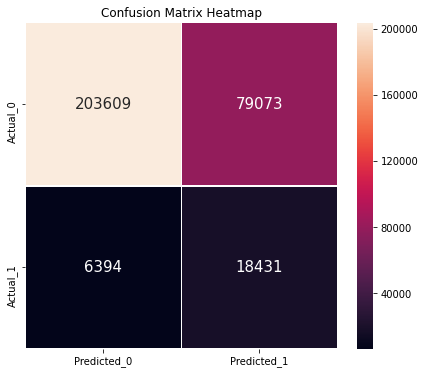

In [ ]:
blended_cv_preds = sgd_lr_l2_cv * 0.020748 + sgd_svm_cv * 0.064836 + rf_cv * 0.003137 + xgb_cv * 0.287625 + lgbm_cv * 0.623653
blended_test_preds = sgd_lr_l2_test * 0.020748 + sgd_svm_test * 0.064836 + rf_test * 0.003137 + xgb_test * 0.287625 + lgbm_test * 0.623653

#tuning the threshold again
fpr, tpr, threshold = roc_curve(target_train, blended_cv_preds)
j = tpr - fpr
best_threshold = threshold[np.argmax(j)]
#calculating the metrics values
print("Results on CV Dataset:")
print("="*100)
print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {best_threshold}\n")
print(f"ROC-AUC Score CV = {roc_auc_score(target_train, blended_cv_preds)}")
print(f"Precison Score CV = {precision_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}")
print(f"Recall Score CV = {recall_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}") 

print('=' * 100)
print("Confusion Matrix of CV data:")
conf_mat = confusion_matrix(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print("="*100)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : blended_test_preds}).to_csv('Blending_all.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Blending_all.csv -m "Blending of results of 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


In [ ]:
results_df = pd.DataFrame([['Random Model', np.round(0.5001812688821752, 5), '-', np.round(0.5001144672273913, 5), '-', 0.49396, 0.50128, '99.37%'],
                            ['Dominant Class', 0.0, '-', np.round(0.5010095061750377, 5), '-', 0.49530, 0.49055, '99.33%'],
                            ['SGD LogisticRegression L2', np.round(0.7472306143001007,5), np.round(0.7363947633434038,5), 
                               np.round(0.7971552091816715,5), np.round(0.7907336258401249,5), 0.77848, 0.78283, '56.51%'],
                            ['SGD Linear SVM', np.round(0.7457804632426989, 5), np.round(0.7369587109768378, 5), 
                                      np.round(0.7980921976293923, 5), np.round(0.7915505286711596, 5), 0.77955, 0.78299, '55.08%'],
                            ['RandomForestClassifier', np.round(0.8091440080563947, 5), np.round(0.7290231621349446, 5),
                                      np.round(0.8321734127843617, 5), np.round(0.7775905555143139, 5), 0.76457, 0.77192, '65.24%'],
                            ['ExtraTreesClassifier', np.round(0.9113393756294058, 5), np.round(0.60269889224572, 5),
                                      np.round(0.932770629575878, 5), np.round(0.7720865925495278, 5), 0.76164, 0.77116, '66.44%'],
                            ['XGBoostClassifier', np.round(0.7999194360523666, 5), np.round(0.8642497482376637, 5), 
                                      np.round(0.8743687606924759, 5), np.round(0.8051278105368123, 5), 0.79513, 0.79729, '6.30%'],
                            ['XGBoostClassifier - 600 Features', np.round(0.8010070493454179, 5), np.round(0.8686807653575025, 5), 
                                      np.round(0.8702218691280733, 5), np.round(0.8046982367776565, 5), 0.79563, 0.79525, '7.26%'],
                            ['LightGBMClassifier', np.round(0.8262638469284995, 5), np.round(0.8406042296072508, 5), 
                                      np.round(0.9045251207764887, 5), np.round(0.8061038615922426, 5), 0.79428, 0.79465, '10.65%'],
                            ['StackingClassifier', np.round(0.736797583081571, 5), np.round(0.9398590130916414, 5),
                                      np.round(0.807872515009856, 5), np.round(0.8066312491185976, 5), 0.79528, 0.79620, '7.23%'],
                            ['Blending Results', '-', np.round(0.7424370594159114, 5), '-', np.round(0.8066127071870559, 5),
                                      0.79565, 0.79707, '6.24%']], 
                          columns = ['Model', 'Train Recall', 'CV Recall', 'Train ROC-AUC', 'CV ROC-AUC', 
                                     'Private Score (ROC-AUC)', 'Public Score (ROC-AUC)', 'Percentile Private LB'], index = list(range(1,12)))

display(results_df)

,Model,Train Recall,CV Recall,Train ROC-AUC,CV ROC-AUC,Private Score (ROC-AUC),Public Score (ROC-AUC),Percentile Private LB
1,Random Model,0.50018,-,0.50011,-,0.49396,0.50128,99.37%
2,Dominant Class,0,-,0.50101,-,0.49530,0.49055,99.33%
3,SGD LogisticRegression L2,0.74723,0.73639,0.79716,0.79073,0.77848,0.78283,56.51%
4,SGD Linear SVM,0.74578,0.73696,0.79809,0.79155,0.77955,0.78299,55.08%
5,RandomForestClassifier,0.80914,0.72902,0.83217,0.77759,0.76457,0.77192,65.24%
6,ExtraTreesClassifier,0.91134,0.6027,0.93277,0.77209,0.76164,0.77116,66.44%
7,XGBoostClassifier,0.79992,0.86425,0.87437,0.80513,0.79513,0.79729,6.30%
8,XGBoostClassifier - 600 Features,0.80101,0.86868,0.87022,0.8047,0.79563,0.79525,7.26%
9,LightGBMClassifier,0.82626,0.8406,0.90453,0.8061,0.79428,0.79465,10.65%
10,StackingClassifier,0.7368,0.93986,0.80787,0.80663,0.79528,0.79620,7.23%


In [ ]:
relational_tables_prepare()

Loading the tables into memory...
Done.
Time Elapsed = 0:02:39.148172

Removing the non-useful features...
Done.
Time Elapsed = 0:00:00.818809

Merging all the tables, and saving to pickle file 'relational_table.pkl'...
Done.
Total Time taken = 0:03:03.547482
